# I. Package

In [1]:
import gurobipy as gp
from gurobipy import GRB
from gurobipy import *

import numpy as np
import pandas as pd
from IPython.display import display

import math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from tabulate import tabulate
import statistics as st
import random
import copy

import seaborn as sns

import time

# II. Pandemic simulation process

In [2]:
def SEIR_simulation(
        
### (1) Input       
        
# (1.1) Population
    terminal_time,               #::Int64,
    susceptible_population,      #::Int64,
    exposed_population,          #::Int64,
    recovered_population,        #::Int64,
    infected_population,         #::Int64,
    cured_population,            #::Int64,
    deaded_population,           #::Int64,
        
# (1.2) contact rate & proportion
    contact_rate,                #::Vector,
    contact_rate_proportion,     #::Vector,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate,              #::Vector,
    exposed_to_infected_rate,    #::Vector,
    recovery_rate_for_exposed,   #::Vector,
    cured_rate_for_infected,     #::Vector,
    death_rate,                  #::Vector,
    sensitivity_proportion,      #::Vector,
        
# (1.4) vaccination strategy
    vaccination_strategy,        #::Function,
    vaccine_efficacy,            #::Float64,
    vaccine_coverage_time,       #::Int64,
    total_time_for_greedy,
        
# (1.5) Output form
    output_presenting_function):  #::Function
    
    
### (2) Define parameters for all group divisions based on activity and sensitivity
    sensitivity_number = len(sensitivity_proportion)
    activity_number = len(contact_rate_proportion)
    N_0 = susceptible_population + exposed_population + recovered_population + infected_population + cured_population
    
    division_number = sensitivity_number * activity_number     # number of divisions
    c = np.zeros(division_number)          # contact rate
    p = np.zeros(division_number)          # proportion
    lambdas = np.zeros(division_number)          # lamda, Infection rate
    gammas = np.zeros(division_number)          # gamma, Exposed to infected rate
    sigma_Es = np.zeros(division_number)          # sigma_E, Recovery rate for exposed
    sigma_Is = np.zeros(division_number)          # sigma_I, Cured rate for infected
    deltas = np.zeros(division_number)          # delta, death rate (case fatality rate)

    for j in range(0,activity_number):
        for i in range(0,sensitivity_number):
            c[(j)*sensitivity_number+i] = contact_rate[j]
            p[(j)*sensitivity_number+i] = contact_rate_proportion[j]*sensitivity_proportion[i]
            lambdas[(j)*sensitivity_number+i] = infection_rate[i]
            gammas[(j)*sensitivity_number+i] = exposed_to_infected_rate[i]
            sigma_Es[(j)*sensitivity_number+i] = recovery_rate_for_exposed[i]
            sigma_Is[(j)*sensitivity_number+i] = cured_rate_for_infected[i]
            deltas[(j)*sensitivity_number+i] = death_rate[i]
        # end for i
    # end for j

# (2.1) Show all the parameters for each division (not be printed out)
    Sensitivity_Matrix = np.zeros((7, division_number))
    Sensitivity_Matrix[0] = p        ; Sensitivity_Matrix[1] = c      
    Sensitivity_Matrix[2] = lambdas  ; Sensitivity_Matrix[3] = gammas  
    Sensitivity_Matrix[4] = sigma_Es ; Sensitivity_Matrix[5] = sigma_Is
    Sensitivity_Matrix[6] = deltas 
    Sensitivity_Matrix_df = pd.DataFrame(Sensitivity_Matrix.T)
    colnames = ["Proportion","Contact rate","Infection rate","Exposed to infected","Recovery rate","Cured rate","Death rate"]
    Sensitivity_Matrix_df.columns = colnames
    
### (3) Prepare to record population in each division for all time
    S = np.zeros((terminal_time+1, division_number))
    dS = np.zeros((terminal_time+1, division_number))
    E = np.zeros((terminal_time+1, division_number))
    R = np.zeros((terminal_time+1, division_number)) 
    I = np.zeros((terminal_time+1, division_number))
    C = np.zeros((terminal_time+1, division_number))
    D = np.zeros((terminal_time+1, division_number))
    dD = np.zeros((terminal_time, division_number)) 
    N = np.zeros((terminal_time+1, division_number))
    V = np.zeros((terminal_time+1, division_number))         # V records vaccinated population of each period 
    Immunized = np.zeros((terminal_time+1, division_number)) # Immunized records the Cumulative vaccinated population 

### (4) Record the intial population 
    S[0,:] = p * susceptible_population    
    E[0,:] = p * exposed_population    
    R[0,:] = p * recovered_population
    I[0,:] = p * infected_population
    C[0,:] = p * cured_population
    D[0,:] = p * deaded_population
    N[0,:] = p * N_0

### (5) Epidemic Simulation
    
# (5.0) Decide maximum vaccine amount for each period
    vaccine_max = N_0/vaccine_coverage_time
    
    for t in range(1,terminal_time+1):  # 1 to terminal_time
    
# (5.1) Vaccination strategy (decide how many people vaccinated in each division)
        
        v = vaccination_strategy(t, 
                                 contact_rate, # this is the rawe input contact rate
                                 c, # this one is a renewed term for each division, others are raw input
                                 infection_rate,
                                 exposed_to_infected_rate,
                                 gammas, # this one is a renewed term for each division, others are raw input
                                 recovery_rate_for_exposed,
                                 cured_rate_for_infected,
                                 death_rate,
                                 vaccine_max, 
                                 # S_t, E_t, R_t, I_t, C_t, D_t, V_t,
                                 S[t-1], E[t-1], R[t-1], I[t-1], C[t-1], D[t-1], Immunized[t-1], 
                                 total_time_for_greedy)
        
        V[t-1] = v                        # Record vaccinated people in period t
        Immunized[t] = sum(V)     # Record total vaccinated people till time t

# (5.1.1) Determine vaccinated proportion for each division among S, E, R states, in case we have 0/(0 + 0 + 0)
    
        vaccinated_proportion_in_S = np.zeros(division_number)
        vaccinated_proportion_in_E = np.zeros(division_number)
        vaccinated_proportion_in_R = np.zeros(division_number)
        
        for k in range(0,division_number): 
            if S[t-1,k] == 0:
                vaccinated_proportion_in_S[k] = 0
            else:
                vaccinated_proportion_in_S[k] = S[t-1,k]/(S[t-1,k]+E[t-1,k]+R[t-1,k])
            # end if
            if E[t-1,k] == 0:
                vaccinated_proportion_in_E[k] = 0
            else:
                vaccinated_proportion_in_E[k] = E[t-1,k]/(S[t-1,k]+E[t-1,k]+R[t-1,k])
            # end if
            if R[t-1,k] == 0:
                vaccinated_proportion_in_R[k] = 0
            else:
                vaccinated_proportion_in_R[k] = R[t-1,k]/(S[t-1,k]+E[t-1,k]+R[t-1,k])
            # end if
        # end for k
    
                    
# (5.2) determine delta S for each division k
  
        for k in range(0,division_number): 
            if S[t-1,k] == 0:   # no more S people, dS will be 0.
                dS[t-1,k] = 0
            else:
                source = sum(c*(E[t-1] - vaccine_efficacy * v * vaccinated_proportion_in_E)) # population contacted by exposed people
            
                # current realized dS can be different from estimation
                if t == 1:
                    random_num = np.random.choice(dS_variation, p=dS_variation_prob)
                    dS[t-1,k] = min(random_num * lambdas[k] * (S[t-1,k] - vaccine_efficacy*v[k]*vaccinated_proportion_in_S[k])/(sum(N[t-1])-sum(I[t-1])) * source, S[t-1,k])
                # future dS still following our estimation
                else:
                    dS[t-1,k] = min(lambdas[k] * (S[t-1,k] - vaccine_efficacy*v[k]*vaccinated_proportion_in_S[k])/(sum(N[t-1])-sum(I[t-1])) * source, S[t-1,k])
                # end if
            
#                 random_num = np.random.choice(dS_variation, p=dS_variation_prob)
#                 dS[t-1,k] = min(random_num * lambdas[k] * (S[t-1,k] - vaccine_efficacy*v[k]*vaccinated_proportion_in_S[k])/(sum(N[t-1])-sum(I[t-1])) * source, S[t-1,k])
            
            # end if  
        # end for k
        
# (5.3) SEIR change: S, E, R, I, C
    
        S[t] = S[t-1] - dS[t-1]                                    - vaccine_efficacy * v * vaccinated_proportion_in_S
        E[t] = E[t-1] + dS[t-1] - sigma_Es*E[t-1] - gammas*E[t-1] - vaccine_efficacy * v * vaccinated_proportion_in_E
        R[t] = R[t-1]           + sigma_Es*E[t-1]                  - vaccine_efficacy * v * vaccinated_proportion_in_R             
        I[t] = I[t-1]                              + gammas*E[t-1] - sigma_Is*I[t-1] - deltas*I[t-1]
        C[t] = C[t-1]                                              + sigma_Is*I[t-1]
        
        for k in range(0,division_number):        # in case the population decreases to negative
            S[t,k] = max(S[t,k], 0)   
            E[t,k] = max(E[t,k], 0)
            R[t,k] = max(R[t,k], 0)
        # end for k

# (5.4) Death occured in t-th period
    
        for k in range(0,division_number): 
            dD[t-1,k] = min(deltas[k]*I[t-1,k], N[t-1,k])
        # end for k
                                        
# (5.5) SEIR change: D, N  
        
        D[t] = D[t-1] + dD[t-1]
        N[t] = N[t-1] - dD[t-1]

    # end for t

### (6) Outcome

    return(output_presenting_function(S, E, R, I, C, D, V, Immunized, terminal_time))
    
# end def

# III. Vaccination Strategies

Input population arranged in the following order:

(1) high contact, high sensitivity; (2) high contact, low sensitivity; (3) low contact, high sensitivity; (4) low contact, low sensitivity;

3.0 No vaccination

In [3]:
def no_vaccination(t_th_period, 
                   unadjusted_contact,
                   contact, 
                        S_to_E_rate,
                        unadjusted_E_to_I_rate,
                   E_to_I_rate, 
                        E_to_R_rate,
                        I_to_C_rate,
                        I_to_D_rate,
                        max_vaccine_amount, 
                        S_t, E_t, R_t, I_t, C_t, D_t, V_t, 
                        T_max_for_greedy):
    return(np.zeros(len(contact)))
# end def

3.1 Proposed vaccination - distribute vaccine based on division's priority, which is "contact rate * sensitivity".

In [4]:
def proposed_vaccination(t_th_period, 
                         unadjusted_contact,
                         contact, 
                        S_to_E_rate,
                        unadjusted_E_to_I_rate,
                         E_to_I_rate, 
                        E_to_R_rate,
                        I_to_C_rate,
                        I_to_D_rate,
                        max_vaccine_amount, 
                        S_t, E_t, R_t, I_t, C_t, D_t, V_t, 
                        T_max_for_greedy):
    
    N_t = S_t + E_t + R_t + I_t + C_t + V_t
    
# initialization before allocating vaccine
    v = np.zeros(len(contact))
    
# defines vaccination priority for each division    
    dividsion_priority = np.zeros(len(contact))  
    for k in range(0,len(contact)):
        dividsion_priority[k] = contact[k] * E_to_I_rate[k]
    # end for k
    
# allocate vaccine based on priority
    for k in range(0,len(contact)):
        order_list = np.argsort(dividsion_priority).tolist() # which group has the lowest to highest priority
        order_list.reverse()                                 # reverse the order to highest to lowest priority
        chosen_group = order_list[k]
        if S_t[chosen_group] + E_t[chosen_group] > 0:
            v[chosen_group] = min((S_t[chosen_group] + E_t[chosen_group] + R_t[chosen_group]), max_vaccine_amount - sum(v)) 
        # end if
     # end for k
    
    return(v)
# end def

3.2 Threhold approach - current protocal method ( based on age, related to sensitivity)

High sensitivity (high risk) first, if same sensitivity, consider contact rate

In [5]:
def sen_1st_con_2nd_vaccination(t_th_period, 
                                unadjusted_contact,
                                contact, 
                        S_to_E_rate,
                        unadjusted_E_to_I_rate,
                        E_to_I_rate, 
                        E_to_R_rate,
                        I_to_C_rate,
                        I_to_D_rate,
                        max_vaccine_amount, 
                        S_t, E_t, R_t, I_t, C_t, D_t, V_t, 
                        T_max_for_greedy):
    
    N_t = S_t + E_t + R_t + I_t + C_t + V_t
    
# initialization before allocating vaccine
    v = np.zeros(len(contact))
    
# defines vaccination priority for each division    
    contact_no_duplicate = [i for n, i in enumerate(contact) if i not in contact[:n]]
    E_to_I_rate_no_duplicate = [i for n, i in enumerate(E_to_I_rate) if i not in E_to_I_rate[:n]]
    largest_priority = len(contact)
    
    dividsion_priority = np.zeros(len(contact))
    for m in range(0,len(contact_no_duplicate)):
        for k in range(0,len(E_to_I_rate_no_duplicate)):
            dividsion_priority[len(contact_no_duplicate) * k + m] = largest_priority
            largest_priority = largest_priority - 1
        # end for k
    # end for m
    
# allocate vaccine based on priority
    for k in range(0,len(contact)):
        order_list = np.argsort(dividsion_priority).tolist() # which group has the lowest to highest priority
        order_list.reverse()                                 # reverse the order to highest to lowest priority
        chosen_group = order_list[k]
        if S_t[chosen_group] + E_t[chosen_group] > 0:
            v[chosen_group] = min((S_t[chosen_group] + E_t[chosen_group] + R_t[chosen_group]), max_vaccine_amount - sum(v))  
        # end if
     # end for k
    
    return(v)
# end def

3.3 Contact rate 1st, sensitivity 2nd approach

In [6]:
def con_1st_sen_2nd_vaccination(t_th_period, 
                                unadjusted_contact,
                                contact, 
                        S_to_E_rate,
                        unadjusted_E_to_I_rate,
                        E_to_I_rate, 
                        E_to_R_rate,
                        I_to_C_rate,
                        I_to_D_rate,
                        max_vaccine_amount, 
                        S_t, E_t, R_t, I_t, C_t, D_t, V_t, 
                        T_max_for_greedy):
    
    N_t = S_t + E_t + R_t + I_t + C_t + V_t
    
# initialization before allocating vaccine
    v = np.zeros(len(contact))
    
# defines vaccination priority for each division   
    dividsion_priority = np.zeros(len(contact))  
    for k in range(0,len(contact)):
        dividsion_priority[k] = len(contact) - k
    # end for k
    
# allocate vaccine based on priority
    for k in range(0,len(contact)):
        order_list = np.argsort(dividsion_priority).tolist() # which group has the lowest to highest priority
        order_list.reverse()                                 # reverse the order to highest to lowest priority
        chosen_group = order_list[k]
        if S_t[chosen_group] + E_t[chosen_group] > 0:
            v[chosen_group] = min((S_t[chosen_group] + E_t[chosen_group] + R_t[chosen_group]), max_vaccine_amount - sum(v))  
        # end if
     # end for k
    
    return(v)
# end def

3.4 Solving static optimization by Greedy approach

In [7]:
def optimal_vaccination(t_th_period, 
                        unadjusted_contact,
                        contact, # this is for all divisions, others are raw input not adjusted for each division
                        S_to_E_rate,
                        unadjusted_E_to_I_rate,
                        E_to_I_rate, # this is for all divisions, others are raw input not adjusted for each division
                        E_to_R_rate,
                        I_to_C_rate,
                        I_to_D_rate,
                        max_vaccine_amount, 
                        S_t, E_t, R_t, I_t, C_t, D_t, V_t, 
                        T_max_for_greedy):
    
    print("----------------------------------------------------------------------------------------------")
    print(t_th_period, "-th period STARTS")
    print("contact = ", unadjusted_contact)
    print("senstivity = ", unadjusted_E_to_I_rate)
    print("S = ", sum(S_t), S_t)
    print("E = ", sum(E_t), E_t)
    print("R = ", sum(R_t), R_t)
    print("I = ", sum(I_t), I_t)
    print("C = ", sum(C_t), C_t)
    print("D = ", sum(D_t), D_t)
    print("V = ", sum(V_t), V_t)
    print("----------------------------------------------------------------------------------------------")
    
    
#     for division in range(0,len(contact)):
#         if S_t[division] <= 0:
#             S_t[division] = 0
    
    SEIR3 = gp.Model("SEIR_contact_sensitivity")
    
    num_of_contact = len(unadjusted_contact)
    num_of_sensitivity = len(unadjusted_E_to_I_rate)
    num_divid = num_of_contact*num_of_sensitivity
    
    N_t = S_t + E_t + R_t + I_t + C_t + V_t
        
    M_big = sum(N_t) * T_max_for_greedy

    # Population of each state
    S_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS) # for t = 0, ..., T and T+1 variables in total
    E_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS)
    R_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS)
    I_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS)
    C_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS)
    D_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS)
    N_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS)
    V_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS)
    dV_population = SEIR3.addVars(T_max_for_greedy, lb = 0, vtype = GRB.CONTINUOUS)
    dS_population = SEIR3.addVars(T_max_for_greedy, lb = 0, vtype = GRB.CONTINUOUS)

    # ij-th division
    S_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # for t = 0, ..., T and T+1 variables in total
    E_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    R_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    I_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    C_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    D_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    N_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    V_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    dV_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    dS_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS)

    E_k_population = SEIR3.addVars(T_max_for_greedy+1,num_of_contact, lb = 0, vtype = GRB.CONTINUOUS)

    # CONTINUOUS variables
    v_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # for t = 0, ..., T-1 and T variables in total
    un_v_S_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # eliminate the highest order term in (2): (1 - v_ij)*S_ij*E_ij
    vv_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # eliminate the highest order term in (5): (1 - v_ij)*(1 - v_ij)
    phi_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.BINARY) # for substitution
    
    # ccp variables
    y_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.BINARY) # for substitution
    rho_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) #CVaR
    z_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # CVaR
    z_ij_1 = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # CVaR
    z_ij_2 = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # CVaR
    z_ij_3 = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # CVaR
    z_ij_4 = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # CVaR
    z_ij_5 = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # CVaR
    est_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # estimation from SEIR model
    beta_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # VaR
    
    obj3 = quicksum(dS_population[t] for t in range(0, T_max_for_greedy))
    SEIR3.setObjective(obj3, GRB.MINIMIZE)
    
    # initial population
    SEIR3.addConstr(S_population[0] == sum(S_t))
    SEIR3.addConstr(E_population[0] == sum(E_t))
    SEIR3.addConstr(R_population[0] == sum(R_t))
    SEIR3.addConstr(I_population[0] == sum(I_t))
    SEIR3.addConstr(C_population[0] == sum(C_t))
    SEIR3.addConstr(D_population[0] == sum(D_t))
    SEIR3.addConstr(N_population[0] == sum(N_t))
    SEIR3.addConstr(V_population[0] == sum(V_t))

    # initial population for each division
    for c_group in range(0,num_of_contact):
        for s_clan in range(0,num_of_sensitivity):
            SEIR3.addConstr(S_ij[0,c_group * num_of_contact + s_clan] == S_t[c_group * num_of_contact + s_clan])
            SEIR3.addConstr(E_ij[0,c_group * num_of_contact + s_clan] == E_t[c_group * num_of_contact + s_clan])
            SEIR3.addConstr(R_ij[0,c_group * num_of_contact + s_clan] == R_t[c_group * num_of_contact + s_clan])
            SEIR3.addConstr(I_ij[0,c_group * num_of_contact + s_clan] == I_t[c_group * num_of_contact + s_clan])
            SEIR3.addConstr(C_ij[0,c_group * num_of_contact + s_clan] == C_t[c_group * num_of_contact + s_clan])
            SEIR3.addConstr(D_ij[0,c_group * num_of_contact + s_clan] == D_t[c_group * num_of_contact + s_clan])
            SEIR3.addConstr(N_ij[0,c_group * num_of_contact + s_clan] == N_t[c_group * num_of_contact + s_clan])
            SEIR3.addConstr(V_ij[0,c_group * num_of_contact + s_clan] == V_t[c_group * num_of_contact + s_clan])
        # end for
    # end for

    # total population = sum of population in each division
    for t in range(1,T_max_for_greedy+1):
        SEIR3.addConstr(S_population[t] == sum(S_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(E_population[t] == sum(E_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(R_population[t] == sum(R_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(I_population[t] == sum(I_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(C_population[t] == sum(C_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(D_population[t] == sum(D_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(V_population[t] == sum(V_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(N_population[t] == sum(N_ij[t,division] for division in range(0,num_divid)))
    
    # total population of dS and dV
    for t in range(0,T_max_for_greedy):
        # optimize dS_popultion, but only consider it as our estimation est_ij
        SEIR3.addConstr(dS_population[t] == quicksum(est_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(dV_population[t] == quicksum(dV_ij[t,division] for division in range(0,num_divid)))


    # source of spreading based on contact rate group
    for t in range(0, T_max_for_greedy):
        for c_group in range(0,num_of_contact):
            SEIR3.addConstr(E_k_population[t,c_group] == quicksum(E_ij[t,c_group * num_of_contact+s_clan] for s_clan in range(0,num_of_sensitivity)))

    # SEIR changes
    for c_group in range(0,num_of_contact):
        for s_clan in range(0,num_of_sensitivity):
            for t in range(0,T_max_for_greedy):
            # simplify terms
                ith = c_group * num_of_contact + s_clan
                source = sum(unadjusted_contact[group] * E_k_population[t,group] for group in range(0,num_of_contact))
            # substitution
                SEIR3.addConstr(un_v_S_ij[t,ith] == (1 - v_ij[t,ith]) * S_ij[t,ith])
                SEIR3.addConstr(vv_ij[t,ith] == (1 - v_ij[t,ith])*(1 - v_ij[t,ith]))
            # linearization of estimated dS = min(A, B)
                SEIR3.addConstr(est_ij[t,ith]*(N_population[t] - I_population[t]) <= un_v_S_ij[t,ith] * S_to_E_rate[s_clan] * source)
                SEIR3.addConstr(est_ij[t,ith] <= un_v_S_ij[t,ith])
                SEIR3.addConstr(est_ij[t,ith]*(N_population[t] - I_population[t]) >= un_v_S_ij[t,ith] * S_to_E_rate[s_clan] * source - M_big*(1 - phi_ij[t,ith])*(N_population[t] - I_population[t]))
                SEIR3.addConstr(est_ij[t,ith] >= un_v_S_ij[t,ith] - M_big*phi_ij[t,ith])
                SEIR3.addConstr(M_big*phi_ij[t,ith]*(N_population[t] - I_population[t]) >= un_v_S_ij[t,ith]*(N_population[t] - I_population[t]) - un_v_S_ij[t,ith] * S_to_E_rate[s_clan] * source)
                SEIR3.addConstr(M_big*(1-phi_ij[t,ith])*(N_population[t] - I_population[t]) >= (un_v_S_ij[t,ith] * S_to_E_rate[s_clan] * source) - un_v_S_ij[t,ith]*(N_population[t] - I_population[t]))
            # really dS_ij can be different from estimated dS_ij
                SEIR3.addConstr(dS_ij[t,ith] == est_ij[t,ith])
            # other SEIR change
                SEIR3.addConstr(S_ij[t+1,ith] == (1 - v_ij[t,ith]) * S_ij[t,ith] - dS_ij[t,ith])
                SEIR3.addConstr(E_ij[t+1,ith] == (1 - v_ij[t,ith]) * (E_ij[t,ith] + dS_ij[t,ith] - E_to_R_rate[s_clan] * E_ij[t,ith] - E_to_I_rate[s_clan] * E_ij[t,ith]))
                SEIR3.addConstr(R_ij[t+1,ith] == (1 - v_ij[t,ith]) * R_ij[t,ith] + vv_ij[t,ith] * E_to_R_rate[s_clan] * E_ij[t,ith])                
                SEIR3.addConstr(I_ij[t+1,ith] == I_ij[t,ith] + (1 - v_ij[t,ith]) * E_to_I_rate[s_clan] * E_ij[t,ith] - I_to_C_rate[s_clan] * I_ij[t,ith] - I_to_D_rate[s_clan] * I_ij[t,ith]) 
                SEIR3.addConstr(C_ij[t+1,ith] == C_ij[t,ith] + I_to_C_rate[s_clan] * I_ij[t,ith])
                SEIR3.addConstr(D_ij[t+1,ith] == D_ij[t,ith] + I_to_D_rate[s_clan] * I_ij[t,ith])
                SEIR3.addConstr(N_ij[t+1,ith] == N_ij[t,ith] - I_to_D_rate[s_clan] * I_ij[t,ith])
                SEIR3.addConstr(dV_ij[t,ith] == v_ij[t,ith]*(S_ij[t,ith] + E_ij[t,ith] + R_ij[t,ith]))
                SEIR3.addConstr(V_ij[t+1,ith] == V_ij[t,ith] + dV_ij[t,ith])
                SEIR3.addConstr(v_ij[t,ith] <= 1)         

    # vaccine limited amount
    for t in range(0,T_max_for_greedy):
        SEIR3.addConstr(quicksum(v_ij[t,division]*(S_ij[t,division] + E_ij[t,division] + R_ij[t,division]) for division in range(0,num_divid)) <= max_vaccine_amount)

    SEIR3.params.NonConvex = 2
    SEIR3.params.timelimit = 60.0
    SEIR3.Params.MIPGap = 0.001
    SEIR3.optimize()
    
    v = np.zeros(len(contact))
    S_population_for_next_round = np.zeros(len(contact))
    E_population_for_next_round = np.zeros(len(contact))
    R_population_for_next_round = np.zeros(len(contact))
    I_population_for_next_round = np.zeros(len(contact))
    C_population_for_next_round = np.zeros(len(contact))
    D_population_for_next_round = np.zeros(len(contact))
    V_population_for_next_round = np.zeros(len(contact))
        
    for division in range(0, num_divid):
        v[division] = dV_ij[0,division].X
        S_population_for_next_round[division] = S_ij[1,division].X
        E_population_for_next_round[division] = E_ij[1,division].X
        R_population_for_next_round[division] = R_ij[1,division].X
        I_population_for_next_round[division] = I_ij[1,division].X
        C_population_for_next_round[division] = C_ij[1,division].X
        D_population_for_next_round[division] = D_ij[1,division].X
        V_population_for_next_round[division] = V_ij[1,division].X
        
    print("----------------------------------------------------------------------------------------------")
    print(t_th_period, "-th period ends")
    print("contact = ", unadjusted_contact)
    print("senstivity = ", unadjusted_E_to_I_rate)
    print("S = ", S_population[1].X)
    print("E = ", E_population[1].X)
    print("R = ", R_population[1].X)
    print("I = ", I_population[1].X)
    print("C = ", C_population[1].X)
    print("D = ", D_population[1].X)
    print("V = ", V_population[1].X)
    print("v = ", v)
    print("----------------------------------------------------------------------------------------------")
    
    
    return(v)    
#     return(v, 
#            S_population_for_next_round, 
#            E_population_for_next_round, 
#            R_population_for_next_round,
#            I_population_for_next_round, 
#            C_population_for_next_round, 
#            D_population_for_next_round, 
#            V_population_for_next_round)

3.5 CCP optimization

In [8]:
def optimal_ccp_vaccination(t_th_period, 
                        unadjusted_contact,
                        contact, # this is for all divisions, others are raw input not adjusted for each division
                        S_to_E_rate,
                        unadjusted_E_to_I_rate,
                        E_to_I_rate, # this is for all divisions, others are raw input not adjusted for each division
                        E_to_R_rate,
                        I_to_C_rate,
                        I_to_D_rate,
                        max_vaccine_amount, 
                        S_t, E_t, R_t, I_t, C_t, D_t, V_t, 
                        T_max_for_greedy):
    
    print("----------------------------------------------------------------------------------------------")
    print(t_th_period, "-th period STARTS")
    print("contact = ", unadjusted_contact)
    print("senstivity = ", unadjusted_E_to_I_rate)
    print("S = ", sum(S_t), S_t)
    print("E = ", sum(E_t), E_t)
    print("R = ", sum(R_t), R_t)
    print("I = ", sum(I_t), I_t)
    print("C = ", sum(C_t), C_t)
    print("D = ", sum(D_t), D_t)
    print("V = ", sum(V_t), V_t)
    print("----------------------------------------------------------------------------------------------")
    
    
#     for division in range(0,len(contact)):
#         if S_t[division] <= 0:
#             S_t[division] = 0
    
    SEIR3 = gp.Model("SEIR_contact_sensitivity")
    
    num_of_contact = len(unadjusted_contact)
    num_of_sensitivity = len(unadjusted_E_to_I_rate)
    num_divid = num_of_contact*num_of_sensitivity
    
    N_t = S_t + E_t + R_t + I_t + C_t + V_t
        
    M_big = sum(N_t) * T_max_for_greedy

    # Population of each state
    S_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS) # for t = 0, ..., T and T+1 variables in total
    E_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS)
    R_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS)
    I_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS)
    C_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS)
    D_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS)
    N_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS)
    V_population = SEIR3.addVars(T_max_for_greedy+1, lb = 0, vtype = GRB.CONTINUOUS)
    dV_population = SEIR3.addVars(T_max_for_greedy, lb = 0, vtype = GRB.CONTINUOUS)
    dS_population = SEIR3.addVars(T_max_for_greedy, lb = 0, vtype = GRB.CONTINUOUS)

    # ij-th division
    S_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # for t = 0, ..., T and T+1 variables in total
    E_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    R_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    I_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    C_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    D_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    N_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    V_ij = SEIR3.addVars(T_max_for_greedy+1,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    dV_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS)
    dS_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS)

    E_k_population = SEIR3.addVars(T_max_for_greedy+1,num_of_contact, lb = 0, vtype = GRB.CONTINUOUS)

    # CONTINUOUS variables
    v_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # for t = 0, ..., T-1 and T variables in total
    un_v_S_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # eliminate the highest order term in (2): (1 - v_ij)*S_ij*E_ij
    vv_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # eliminate the highest order term in (5): (1 - v_ij)*(1 - v_ij)
    phi_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.BINARY) # for substitution
    
    # ccp variables
    y_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.BINARY) # for substitution
    rho_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) #VaR
    z_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # CVaR
    z_ij_1 = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # CVaR
    z_ij_2 = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # CVaR
    z_ij_3 = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # CVaR
    z_ij_4 = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # CVaR
    z_ij_5 = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # CVaR
    est_ij = SEIR3.addVars(T_max_for_greedy,num_divid, lb = 0, vtype = GRB.CONTINUOUS) # estimation from SEIR model
    
    # objective
    obj3 = quicksum(dS_population[t] for t in range(0, T_max_for_greedy))
    SEIR3.setObjective(obj3, GRB.MINIMIZE)
    
    # initial population
    SEIR3.addConstr(S_population[0] == sum(S_t))
    SEIR3.addConstr(E_population[0] == sum(E_t))
    SEIR3.addConstr(R_population[0] == sum(R_t))
    SEIR3.addConstr(I_population[0] == sum(I_t))
    SEIR3.addConstr(C_population[0] == sum(C_t))
    SEIR3.addConstr(D_population[0] == sum(D_t))
    SEIR3.addConstr(N_population[0] == sum(N_t))
    SEIR3.addConstr(V_population[0] == sum(V_t))

    # initial population for each division
    for c_group in range(0,num_of_contact):
        for s_clan in range(0,num_of_sensitivity):
            SEIR3.addConstr(S_ij[0,c_group * num_of_contact + s_clan] == S_t[c_group * num_of_contact + s_clan])
            SEIR3.addConstr(E_ij[0,c_group * num_of_contact + s_clan] == E_t[c_group * num_of_contact + s_clan])
            SEIR3.addConstr(R_ij[0,c_group * num_of_contact + s_clan] == R_t[c_group * num_of_contact + s_clan])
            SEIR3.addConstr(I_ij[0,c_group * num_of_contact + s_clan] == I_t[c_group * num_of_contact + s_clan])
            SEIR3.addConstr(C_ij[0,c_group * num_of_contact + s_clan] == C_t[c_group * num_of_contact + s_clan])
            SEIR3.addConstr(D_ij[0,c_group * num_of_contact + s_clan] == D_t[c_group * num_of_contact + s_clan])
            SEIR3.addConstr(N_ij[0,c_group * num_of_contact + s_clan] == N_t[c_group * num_of_contact + s_clan])
            SEIR3.addConstr(V_ij[0,c_group * num_of_contact + s_clan] == V_t[c_group * num_of_contact + s_clan])
        # end for
    # end for

    # total population = sum of population in each division
    for t in range(1,T_max_for_greedy+1):
        SEIR3.addConstr(S_population[t] == sum(S_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(E_population[t] == sum(E_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(R_population[t] == sum(R_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(I_population[t] == sum(I_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(C_population[t] == sum(C_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(D_population[t] == sum(D_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(V_population[t] == sum(V_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(N_population[t] == sum(N_ij[t,division] for division in range(0,num_divid)))
    
    # total population of dS and dV
    for t in range(0,T_max_for_greedy):
        # optimize dS_popultion, but only consider it as our estimation est_ij
        SEIR3.addConstr(dS_population[t] == quicksum(est_ij[t,division] for division in range(0,num_divid)))
        #SEIR3.addConstr(dS_population[t] == quicksum(dS_ij[t,division] for division in range(0,num_divid)))
        SEIR3.addConstr(dV_population[t] == quicksum(dV_ij[t,division] for division in range(0,num_divid)))


    # source of spreading based on contact rate group
    for t in range(0, T_max_for_greedy):
        for c_group in range(0,num_of_contact):
            SEIR3.addConstr(E_k_population[t,c_group] == quicksum(E_ij[t,c_group * num_of_contact+s_clan] for s_clan in range(0,num_of_sensitivity)))

    # SEIR changes
    for c_group in range(0,num_of_contact):
        for s_clan in range(0,num_of_sensitivity):
            for t in range(0,T_max_for_greedy):
            # simplify terms
                ith = c_group * num_of_contact + s_clan
                source = sum(unadjusted_contact[group] * E_k_population[t,group] for group in range(0,num_of_contact))
            # substitution
                SEIR3.addConstr(un_v_S_ij[t,ith] == (1 - v_ij[t,ith]) * S_ij[t,ith])
                SEIR3.addConstr(vv_ij[t,ith] == (1 - v_ij[t,ith])*(1 - v_ij[t,ith]))
            # linearization of estimated dS = min(A, B)
                SEIR3.addConstr(est_ij[t,ith]*(N_population[t] - I_population[t]) <= un_v_S_ij[t,ith] * S_to_E_rate[s_clan] * source)
                SEIR3.addConstr(est_ij[t,ith] <= un_v_S_ij[t,ith])
                SEIR3.addConstr(est_ij[t,ith]*(N_population[t] - I_population[t]) >= un_v_S_ij[t,ith] * S_to_E_rate[s_clan] * source - M_big*(1 - phi_ij[t,ith])*(N_population[t] - I_population[t]))
                SEIR3.addConstr(est_ij[t,ith] >= un_v_S_ij[t,ith] - M_big*phi_ij[t,ith])
                SEIR3.addConstr(M_big*phi_ij[t,ith]*(N_population[t] - I_population[t]) >= un_v_S_ij[t,ith]*(N_population[t] - I_population[t]) - un_v_S_ij[t,ith] * S_to_E_rate[s_clan] * source)
                SEIR3.addConstr(M_big*(1-phi_ij[t,ith])*(N_population[t] - I_population[t]) >= (un_v_S_ij[t,ith] * S_to_E_rate[s_clan] * source) - un_v_S_ij[t,ith]*(N_population[t] - I_population[t]))
            # current realized dS_ij can be different from estimated dS_ij
                if t == 0:
                    random_num = np.random.choice(dS_variation, p=dS_variation_prob)
                    SEIR3.addConstr(dS_ij[t,ith] == est_ij[t,ith] * random_num)
            # future dS_ij following out estimation
                else:
                    SEIR3.addConstr(dS_ij[t,ith] == est_ij[t,ith])
            # other SEIR change
                SEIR3.addConstr(S_ij[t+1,ith] == (1 - v_ij[t,ith]) * S_ij[t,ith] - dS_ij[t,ith])
                SEIR3.addConstr(E_ij[t+1,ith] == (1 - v_ij[t,ith]) * (E_ij[t,ith] + dS_ij[t,ith] - E_to_R_rate[s_clan] * E_ij[t,ith] - E_to_I_rate[s_clan] * E_ij[t,ith]))
                SEIR3.addConstr(R_ij[t+1,ith] == (1 - v_ij[t,ith]) * R_ij[t,ith] + vv_ij[t,ith] * E_to_R_rate[s_clan] * E_ij[t,ith])                
                SEIR3.addConstr(I_ij[t+1,ith] == I_ij[t,ith] + (1 - v_ij[t,ith]) * E_to_I_rate[s_clan] * E_ij[t,ith] - I_to_C_rate[s_clan] * I_ij[t,ith] - I_to_D_rate[s_clan] * I_ij[t,ith]) 
                SEIR3.addConstr(C_ij[t+1,ith] == C_ij[t,ith] + I_to_C_rate[s_clan] * I_ij[t,ith])
                SEIR3.addConstr(D_ij[t+1,ith] == D_ij[t,ith] + I_to_D_rate[s_clan] * I_ij[t,ith])
                SEIR3.addConstr(N_ij[t+1,ith] == N_ij[t,ith] - I_to_D_rate[s_clan] * I_ij[t,ith])
                SEIR3.addConstr(dV_ij[t,ith] == v_ij[t,ith]*(S_ij[t,ith] + E_ij[t,ith] + R_ij[t,ith]))
                SEIR3.addConstr(V_ij[t+1,ith] == V_ij[t,ith] + dV_ij[t,ith])
                SEIR3.addConstr(v_ij[t,ith] <= 1)
            # VaR
                SEIR3.addConstr(rho_ij[t,ith] >= est_ij[t,ith])
            # CVaR: possibile situations for z
                SEIR3.addConstr(z_ij_1[t,ith] >= dS_variation[0]*dS_ij[t,ith] - rho_ij[t,ith])
                SEIR3.addConstr(z_ij_2[t,ith] >= dS_variation[1]*dS_ij[t,ith] - rho_ij[t,ith])
                SEIR3.addConstr(z_ij_3[t,ith] >= dS_variation[2]*dS_ij[t,ith] - rho_ij[t,ith])
                SEIR3.addConstr(z_ij_4[t,ith] >= dS_variation[3]*dS_ij[t,ith] - rho_ij[t,ith])
                SEIR3.addConstr(z_ij_5[t,ith] >= dS_variation[4]*dS_ij[t,ith] - rho_ij[t,ith])
                z_possibility = [z_ij_1[t,ith], z_ij_2[t,ith], z_ij_3[t,ith], z_ij_4[t,ith], z_ij_5[t,ith]]
            # CVaR: expectation of z
                E_z_ij = sum(np.multiply(z_possibility, dS_variation_prob))
            # CVaR: formulation
                SEIR3.addConstr(rho_ij[t,ith] + (1/(1 - ALPHA)) * E_z_ij >= est_ij[t,ith])
            # CVaR: linear of z = max(0, dS - rho)
                SEIR3.addConstr(rho_ij[t,ith] - dS_ij[t,ith] <= M_big*y_ij[t,ith])
                SEIR3.addConstr(dS_ij[t,ith] - rho_ij[t,ith] <= M_big*(1 - y_ij[t,ith]))
                SEIR3.addConstr(z_ij[t,ith] >= dS_ij[t,ith] - rho_ij[t,ith])
                SEIR3.addConstr(z_ij[t,ith] <= M_big*(1 - y_ij[t,ith]))
                SEIR3.addConstr(z_ij[t,ith] <= dS_ij[t,ith] - rho_ij[t,ith] + M_big*y_ij[t,ith])

    # vaccine limited amount
    for t in range(0,T_max_for_greedy):
        SEIR3.addConstr(quicksum(v_ij[t,division]*(S_ij[t,division] + E_ij[t,division] + R_ij[t,division]) for division in range(0,num_divid)) <= max_vaccine_amount)

    SEIR3.params.NonConvex = 2
    SEIR3.params.timelimit = 60.0
    SEIR3.Params.MIPGap = 0.001
    SEIR3.optimize()
    
    v = np.zeros(len(contact))
    S_population_for_next_round = np.zeros(len(contact))
    E_population_for_next_round = np.zeros(len(contact))
    R_population_for_next_round = np.zeros(len(contact))
    I_population_for_next_round = np.zeros(len(contact))
    C_population_for_next_round = np.zeros(len(contact))
    D_population_for_next_round = np.zeros(len(contact))
    V_population_for_next_round = np.zeros(len(contact))
        
    for division in range(0, num_divid):
        v[division] = dV_ij[0,division].X
        S_population_for_next_round[division] = S_ij[1,division].X
        E_population_for_next_round[division] = E_ij[1,division].X
        R_population_for_next_round[division] = R_ij[1,division].X
        I_population_for_next_round[division] = I_ij[1,division].X
        C_population_for_next_round[division] = C_ij[1,division].X
        D_population_for_next_round[division] = D_ij[1,division].X
        V_population_for_next_round[division] = V_ij[1,division].X
        
    print("----------------------------------------------------------------------------------------------")
    print(t_th_period, "-th period ends")
    print("contact = ", unadjusted_contact)
    print("senstivity = ", unadjusted_E_to_I_rate)
    print("S = ", S_population[1].X)
    print("E = ", E_population[1].X)
    print("R = ", R_population[1].X)
    print("I = ", I_population[1].X)
    print("C = ", C_population[1].X)
    print("D = ", D_population[1].X)
    print("V = ", V_population[1].X)
    print("v = ", v)
    print("----------------------------------------------------------------------------------------------")
    
    
    return(v)    
#     return(v, 
#            S_population_for_next_round, 
#            E_population_for_next_round, 
#            R_population_for_next_round,
#            I_population_for_next_round, 
#            C_population_for_next_round, 
#            D_population_for_next_round, 
#            V_population_for_next_round)

# IV. Output Result

4.1 Output - Population change line chart

In [9]:
def plot_population_change(susceptible_population,
                           exposed_population,
                           recovered_population,
                           infected_population,
                           cured_population,
                           deaded_population,
                           vaccinated_population,
                           immunized_population,
                           T_max):
    max_x = max( max(sum(susceptible_population.T)),
                 max(sum(exposed_population.T)),
                 max(sum(recovered_population.T)),
                 max(sum(infected_population.T)),
                 max(sum(cured_population.T)),
                 max(sum(deaded_population.T)),
                 max(sum(immunized_population.T)) )
    figure = plt.figure()
    plt.xlabel("Time (week)")
    plt.ylabel("Population")
    plt.xlim(0, T_max)
    plt.ylim(0, max_x)
    plt.plot(sum(susceptible_population.T), label="Susceptible", color="lime")
    plt.plot(sum(exposed_population.T), label="Exposed",     color="orange")
    plt.plot(sum(recovered_population.T), label="Recovered",   color="deepskyblue")
    plt.plot(sum(infected_population.T), label="Infected",    color="red")
    plt.plot(sum(cured_population.T), label="Cured",       color="royalblue")
    plt.plot(sum(deaded_population.T), label="Death",       color="black")
    plt.plot(sum(immunized_population.T), label="Vaccinated", color="hotpink")
    plt.legend()
    
# end def

4.2 Output - Population

In [10]:
def give_population_df(susceptible_population,
                    exposed_population,
                    recovered_population,
                    infected_population,
                    cured_population,
                    deaded_population,
                    vaccinated_population,
                    immunized_population,
                    T_max):
    Population_Matrix = np.zeros((8, T_max+1))
    Population_Matrix[0,:] = sum(susceptible_population.T)
    Population_Matrix[1,:] = sum(exposed_population.T)
    Population_Matrix[2,:] = sum(recovered_population.T)
    Population_Matrix[3,:] = sum(infected_population.T)
    Population_Matrix[4,:] = sum(cured_population.T)
    Population_Matrix[5,:] = sum(deaded_population.T)
    Population_Matrix[6,:] = sum(immunized_population.T)
    Population_Matrix[7,:] = sum(vaccinated_population.T)
    Population_Matrix_dataframe = pd.DataFrame(Population_Matrix.T)
    colnames = ["Susceptible","Exposed","Recovered","Infected","Cured","Death","Immunized", "Vaccinated"]
    Population_Matrix_dataframe.columns = colnames
    return(Population_Matrix_dataframe)
# end def

4.3 Output - Performance: Highest infection and when, total death, and total vaccination

In [11]:
def give_performance(susceptible_population,
                     exposed_population,
                     recovered_population,
                     infected_population,
                     cured_population,
                     deaded_population,
                     vaccinated_population,
                     immunized_population,
                     T_max):
    Performance_Matrix = np.zeros(7)
# highest infection population
    Performance_Matrix[0] = max(sum(infected_population.T))
# when highest I population appear
    Performance_Matrix[1] = np.argmax(sum(infected_population.T))
# highest infection proportion among all current alive people
    Performance_Matrix[2] = max(sum(infected_population.T)/(sum(susceptible_population.T)
                                                                +sum(exposed_population.T)
                                                                +sum(recovered_population.T)
                                                                +sum(infected_population.T)
                                                                +sum(cured_population.T)
                                                                +sum(vaccinated_population.T)))
# when does the highest I proportion appear
    Performance_Matrix[3] = np.argmax(sum(infected_population.T)/(sum(susceptible_population.T)
                                                                +sum(exposed_population.T)
                                                                +sum(recovered_population.T)
                                                                +sum(infected_population.T)
                                                                +sum(cured_population.T)
                                                                +sum(vaccinated_population.T)))
# Final death number
    Performance_Matrix[4] = sum(deaded_population.T)[-1]
# Final death rate
    Performance_Matrix[5] = (sum(deaded_population.T)[-1])/((sum(susceptible_population.T)
                                                            +sum(exposed_population.T)
                                                            +sum(recovered_population.T)
                                                            +sum(infected_population.T)
                                                            +sum(cured_population.T)
                                                            +sum(vaccinated_population.T))[0]) # divided by the initial population
# Total immunized population
    Performance_Matrix[6] = sum(immunized_population[T_max])
    
    Performance_Matrix_dataframe = pd.DataFrame(Performance_Matrix).T
    colnames = ["Highest I","When 1","Highest I %","When 2","Total D","Fatality rate","Total vaccinated"]
    Performance_Matrix_dataframe.columns = colnames
    return(Performance_Matrix_dataframe)
# end def

4.4 Output - Population (as table)

In [12]:
def give_population_table(susceptible_population,
                    exposed_population,
                    recovered_population,
                    infected_population,
                    cured_population,
                    deaded_population,
                    vaccinated_population,
                    immunized_population,
                    T_max):
    Population_Matrix = np.zeros((8, T_max+1))
    Population_Matrix[0,:] = sum(susceptible_population.T)
    Population_Matrix[1,:] = sum(exposed_population.T)
    Population_Matrix[2,:] = sum(recovered_population.T)
    Population_Matrix[3,:] = sum(infected_population.T)
    Population_Matrix[4,:] = sum(cured_population.T)
    Population_Matrix[5,:] = sum(deaded_population.T)
    Population_Matrix[6,:] = sum(immunized_population.T)
    Population_Matrix[6,:] = sum(vaccinated_population.T)
    return(Population_Matrix)
# end def

4.5 Output - Evaluation (as table or vector)

In [13]:
def give_performance_table(susceptible_population,
                     exposed_population,
                     recovered_population,
                     infected_population,
                     cured_population,
                     deaded_population,
                     vaccinated_population,
                     immunized_population,
                     T_max):
    Performance_Matrix = np.zeros(7)
# highest infection population
    Performance_Matrix[0] = max(sum(infected_population.T))
# when highest I population appear
    Performance_Matrix[1] = np.argmax(sum(infected_population.T))
# highest infection proportion among all current alive people
    Performance_Matrix[2] = max(sum(infected_population.T)/(sum(susceptible_population.T)
                                                                +sum(exposed_population.T)
                                                                +sum(recovered_population.T)
                                                                +sum(infected_population.T)
                                                                +sum(cured_population.T)
                                                                +sum(vaccinated_population.T)))
# when does the highest I proportion appear
    Performance_Matrix[3] = np.argmax(sum(infected_population.T)/(sum(susceptible_population.T)
                                                                +sum(exposed_population.T)
                                                                +sum(recovered_population.T)
                                                                +sum(infected_population.T)
                                                                +sum(cured_population.T)
                                                                +sum(vaccinated_population.T)))
# Final death number
    Performance_Matrix[4] = sum(deaded_population.T)[-1]
# Final death rate
    Performance_Matrix[5] = (sum(deaded_population.T)[-1])/((sum(susceptible_population.T)
                                                            +sum(exposed_population.T)
                                                            +sum(recovered_population.T)
                                                            +sum(infected_population.T)
                                                            +sum(cured_population.T)
                                                            +sum(vaccinated_population.T))[0]) # divided by the initial population
# Total immunized population
    Performance_Matrix[6] = sum(immunized_population[T_max])
    return(Performance_Matrix)
# end def

4.6 Output - population for each division

In [14]:
def give_population_by_division(susceptible_population,
                     exposed_population,
                     recovered_population,
                     infected_population,
                     cured_population,
                     deaded_population,
                     vaccinated_population,
                     immunized_population,
                     T_max):
    return(susceptible_population,
                     exposed_population,
                     recovered_population,
                     infected_population,
                     cured_population,
                     deaded_population,
                     immunized_population,
                      vaccinated_population)
# end def

4.7 Output - compare population for all strategy

In [15]:
figx = 6
figy = 4

In [16]:
def plot_to_compare_popluation_ovetime(population_c_and_s,
                                        population_s1c2,
                                        population_c1s2,
                                       population_static,
                                       population_ccp,
                                      exhibition_length,
                                      size_font):
    max_y = max(max(population_c_and_s),
                max(population_s1c2),
                max(population_c1s2),
                max(population_static),
                max(population_ccp) ) * 1.025
    max_x = exhibition_length
    figure = plt.figure()
    plt.figure(figsize=(figx, figy))
    plt.xlabel("Time (week)", fontsize = size_font)
    plt.xlim(0, max_x)
    plt.ylim(0, max_y)
    plt.plot(population_c_and_s,label="1 C*S",    color="red",         marker = 'D', markersize = 8, linewidth=3)
    plt.plot(population_s1c2,   label="2 S1C2",   color="orange",      marker = 'o', markersize = 8, linewidth=3)
    plt.plot(population_c1s2,   label="3 C1S2",   color="lime",        marker = 'x', markersize = 8, linewidth=3)
    plt.plot(population_static, label="4 Static", color="deepskyblue", marker = '*', markersize = 8, linewidth=3)
    plt.plot(population_ccp,    label="5 CCP",    color="royalblue",   marker = '+', markersize = 8, linewidth=3)
    plt.grid()
    plt.tick_params(labelsize = size_font)
    
    #return(figure)

In [17]:
def plot_to_compare_popluation_ovetime_legend(population_c_and_s,
                                            population_s1c2,
                                            population_c1s2,
                                               population_static,
                                           population_ccp,
                                          exhibition_length,
                                          size_font):
    max_y = max(max(population_c_and_s),
                max(population_s1c2),
                max(population_c1s2),
                max(population_static),
                max(population_ccp) ) * 1.025
    max_x = exhibition_length
    figure = plt.figure()
    plt.figure(figsize=(figx, figy))
    plt.xlabel("Time (week)", fontsize = size_font)
    plt.xlim(0, max_x)
    plt.ylim(0, max_y)
    plt.plot(population_c_and_s,label="1 C*S",    color="red",         marker = 'D', markersize = 8, linewidth=3)
    plt.plot(population_s1c2,   label="2 S1C2",   color="orange",      marker = 'o', markersize = 8, linewidth=3)
    plt.plot(population_c1s2,   label="3 C1S2",   color="lime",        marker = 'x', markersize = 8, linewidth=3)
    plt.plot(population_static, label="4 Static", color="deepskyblue", marker = '*', markersize = 8, linewidth=3)
    plt.plot(population_ccp,    label="5 CCP",    color="royalblue",   marker = '+', markersize = 8, linewidth=3)
# plot legend
    plt.legend(loc = 'lower right', prop = {'size':size_font})
    plt.grid()
    plt.tick_params(labelsize = size_font)

    #return(figure)

In [18]:
def plot_to_compare_vaccinated_per_period_legend(vaccinated_population_per_period,
                                          exhibition_length,
                                          size_font):
    max_y = max(max(vaccinated_population_per_period[0]),
                max(vaccinated_population_per_period[1]),
                max(vaccinated_population_per_period[2]),
                max(vaccinated_population_per_period[3]),) * 1.025
    max_x = exhibition_length
    figure = plt.figure()
    plt.figure(figsize=(figx, figy))
    plt.xlabel("Time (week)", fontsize = size_font)
    plt.xlim(0, max_x)
    plt.ylim(0, max_y)
    plt.plot(vaccinated_population_per_period[0], label="S_h,C_h", color="red",         marker = 'D', markersize = 8, linewidth=2)
    plt.plot(vaccinated_population_per_period[1], label="S_l,C_h", color="orange",      marker = 'o', markersize = 8, linewidth=2)
    plt.plot(vaccinated_population_per_period[2], label="S_h,C_l", color="lime",        marker = 'x', markersize = 8, linewidth=2)
    plt.plot(vaccinated_population_per_period[3], label="S_h,C_l", color="deepskyblue", marker = '+', markersize = 8, linewidth=2)
    plt.legend(loc = 'upper right', prop = {'size':size_font})
    plt.grid()
    plt.tick_params(labelsize = size_font)

In [19]:
def plot_to_compare_vaccinated_per_period(vaccinated_population_per_period,
                                          exhibition_length,
                                          size_font):
    max_y = max(max(vaccinated_population_per_period[0]),
                max(vaccinated_population_per_period[1]),
                max(vaccinated_population_per_period[2]),
                max(vaccinated_population_per_period[3]),) * 1.025
    max_x = exhibition_length
    figure = plt.figure()
    plt.figure(figsize=(figx, figy))
    plt.xlabel("Time (week)", fontsize = size_font)
    plt.xlim(0, max_x)
    plt.ylim(0, max_y)
    plt.plot(vaccinated_population_per_period[0], label="S_h,C_h", color="red",         marker = 'D', markersize = 8, linewidth=2)
    plt.plot(vaccinated_population_per_period[1], label="S_l,C_h", color="orange",      marker = 'o', markersize = 8, linewidth=2)
    plt.plot(vaccinated_population_per_period[2], label="S_h,C_l", color="lime",        marker = 'x', markersize = 8, linewidth=2)
    plt.plot(vaccinated_population_per_period[3], label="S_h,C_l", color="deepskyblue", marker = '+', markersize = 8, linewidth=2)
    plt.grid()
    plt.tick_params(labelsize = size_font)

# V. SEIR Simulation Input

5.1 Sensitivity parameters - how likely to get infected and develop symtoms or recover

In [20]:
Lambdas = [0.1, 0.1]     # Infection rate 0.02 ~ 0.6
Gammas = [1/5, 1/10]      # Exposed to infected rate 1/14 ~ 1/5
Sigma_Es = [1/14, 1/14]     # Recovery rate for exposed 1/14
Sigma_Is = [1/20, 1/10]     # Cured rate for infected 1/20 ~ 1/10
Deltas = [0.025, 0.025]   # Death rate (case fatality rate) 2.3% ~ 2.6%
p_i = [0.5, 0.5]       # proportion corresponding to sensitivity clan

5.2 Social activity parameters - based on number of contatcs

In [21]:
c_j = [25, 15]             # contact rates for different social activity level group
p_j = [0.5, 0.5]        # proportion corresponding to contact rates

5.3 State population - how many people in each states defined by SEIR model

In [32]:
T = 50        # Terminal time in week
T_greedy = 3  # number of periods used for greedy
S_0 = 100000    # Initial number of susceptible
E_0 = 50        # Initial number of exposed
R_0 = 0         # Initial number of recovered from E
I_0 = 0         # Initial number of infected 
C_0 = 0         # Initial number of recovered from R
D_0 = 0         # Initial number of Death

5.4 Vaccine Statistics Input

In [23]:
coverage_time = 100 # in weeks
v_epsilon = 0.9

5.5 Stochastic variation of dS

In [47]:
ALPHA = 0.05
dS_variation = np.array([0.9, 0.95, 1, 1.05, 1.1])

# dS_variation_prob = np.array([0.0, 0.0, 1, 0.0, 0.0])
# dS_variation_prob = np.array([0.01, 0.1, 0.78, 0.1, 0.01])
dS_variation_prob = np.array([0.05, 0.2, 0.5, 0.2, 0.05])
# dS_variation_prob = np.array([0.1, 0.15, 0.5, 0.15, 0.1])

Repeat_time = 10

# VI. Epidemic Simulation

6.1 Contact rate & sensitivity vaccination - distribute vaccine based on division's priority, which is "contact rate * sensitivity".

In [25]:
start = time.time()

# 1st simulation
simulation_test_population_c_and_s_total = SEIR_simulation(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
    
# (1.4) vaccination strategy (Only thing need to change before running)
    vaccination_strategy        = proposed_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = T_greedy,

# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
    output_presenting_function  = give_population_table
    )

# rest simulations
for repeat in range(Repeat_time-1):
    simulation_test_population_c_and_s_single_run = SEIR_simulation(
        
### (1) Input       
        
# (1.1) Population
        terminal_time               = T,
        susceptible_population      = S_0,
        exposed_population          = E_0,
        recovered_population        = R_0,
        infected_population         = I_0,
        cured_population            = C_0,
        deaded_population           = D_0,
        
# (1.2) contact rate & proportion
        contact_rate                = c_j,
        contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
        infection_rate              = Lambdas,
        exposed_to_infected_rate    = Gammas,
        recovery_rate_for_exposed   = Sigma_Es,
        cured_rate_for_infected     = Sigma_Is,
        death_rate                  = Deltas,
        sensitivity_proportion      = p_i,
    
# (1.4) vaccination strategy (Only thing need to change before running)
        vaccination_strategy        = proposed_vaccination,
        vaccine_efficacy            = v_epsilon,
        vaccine_coverage_time       = coverage_time,
        total_time_for_greedy       = T_greedy,

# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
        output_presenting_function  = give_population_table
    )
    simulation_test_population_c_and_s_total = simulation_test_population_c_and_s_total + simulation_test_population_c_and_s_single_run

end = time.time()
print("computing time =", end - start)

simulation_test_population_c_and_s = simulation_test_population_c_and_s_total/Repeat_time

computing time = 0.06174111366271973


6.2 Current protocal approach - Sensitivity 1st Contact 2nd

In [26]:
start = time.time()

# 1st simulation
simulation_test_population_s1c2_total = SEIR_simulation(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
    
# (1.4) vaccination strategy (Only thing need to change before running)
    vaccination_strategy        = sen_1st_con_2nd_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = T_greedy,

# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
    output_presenting_function  = give_population_table
    )

# rest simulations
for repeat in range(Repeat_time-1):
    simulation_test_population_s1c2_single_run = SEIR_simulation(
        
### (1) Input       
        
# (1.1) Population
        terminal_time               = T,
        susceptible_population      = S_0,
        exposed_population          = E_0,
        recovered_population        = R_0,
        infected_population         = I_0,
        cured_population            = C_0,
        deaded_population           = D_0,
        
# (1.2) contact rate & proportion
        contact_rate                = c_j,
        contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
        infection_rate              = Lambdas,
        exposed_to_infected_rate    = Gammas,
        recovery_rate_for_exposed   = Sigma_Es,
        cured_rate_for_infected     = Sigma_Is,
        death_rate                  = Deltas,
        sensitivity_proportion      = p_i,
    
# (1.4) vaccination strategy (Only thing need to change before running)
        vaccination_strategy        = sen_1st_con_2nd_vaccination,
        vaccine_efficacy            = v_epsilon,
        vaccine_coverage_time       = coverage_time,
        total_time_for_greedy       = T_greedy,

# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
        output_presenting_function  = give_population_table
    )
    simulation_test_population_s1c2_total = simulation_test_population_s1c2_total + simulation_test_population_s1c2_single_run

end = time.time()
print("computing time =", end - start)

simulation_test_population_s1c2 = simulation_test_population_s1c2_total/Repeat_time

computing time = 0.07588601112365723


6.3 Contact 1st Sensitivity 2nd approach

In [27]:
start = time.time()

# 1st simulation
simulation_test_population_c1s2_total = SEIR_simulation(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
    
# (1.4) vaccination strategy (Only thing need to change before running)
    vaccination_strategy        = con_1st_sen_2nd_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = T_greedy,

# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
    output_presenting_function  = give_population_table
    )

# rest simulations
for repeat in range(Repeat_time-1):
    simulation_test_population_c1s2_single_run = SEIR_simulation(
        
### (1) Input       
        
# (1.1) Population
        terminal_time               = T,
        susceptible_population      = S_0,
        exposed_population          = E_0,
        recovered_population        = R_0,
        infected_population         = I_0,
        cured_population            = C_0,
        deaded_population           = D_0,
        
# (1.2) contact rate & proportion
        contact_rate                = c_j,
        contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
        infection_rate              = Lambdas,
        exposed_to_infected_rate    = Gammas,
        recovery_rate_for_exposed   = Sigma_Es,
        cured_rate_for_infected     = Sigma_Is,
        death_rate                  = Deltas,
        sensitivity_proportion      = p_i,
    
# (1.4) vaccination strategy (Only thing need to change before running)
        vaccination_strategy        = con_1st_sen_2nd_vaccination,
        vaccine_efficacy            = v_epsilon,
        vaccine_coverage_time       = coverage_time,
        total_time_for_greedy       = T_greedy,

# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
        output_presenting_function  = give_population_table
    )
    simulation_test_population_c1s2_total = simulation_test_population_c1s2_total + simulation_test_population_c1s2_single_run
    
end = time.time()
print("computing time =", end - start)

simulation_test_population_c1s2 = simulation_test_population_c1s2_total/Repeat_time

computing time = 0.05570387840270996


6.4 solve optimizaiton by Greedy approach - 4 (1 + 3 periods)

In [33]:
start = time.time()

simulation_test_population_static_optimal = SEIR_simulation(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
        
# (1.4) vaccination strategy (Only thing need to change before running)
    vaccination_strategy        = optimal_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = T_greedy,
    
# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
#     output_presenting_function  = plot_population_change
#     output_presenting_function  = give_population_df
    output_presenting_function  = give_population_table
#     output_presenting_function  = give_performance
    
    )

end = time.time()
print("computing time =", end - start)

----------------------------------------------------------------------------------------------
1 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  100000.0 [25000. 25000. 25000. 25000.]
E =  50.0 [12.5 12.5 12.5 12.5]
R =  0.0 [0. 0. 0. 0.]
I =  0.0 [0. 0. 0. 0.]
C =  0.0 [0. 0. 0. 0.]
D =  0.0 [0. 0. 0. 0.]
V =  0.0 [0. 0. 0. 0.]
----------------------------------------------------------------------------------------------
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 172 rows, 366 columns and 448 nonzeros
Model fingerprint: 0xbce1f6b2
Model has 135 quadratic constraints
Variable types: 342 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 7272.99504    0   72          - 7272.99504      -     -    0s
H    0     0                    7298.1991013 7272.99504  0.35%     -    0s
     0     0 7283.25265    0   65 7298.19910 7283.25265  0.20%     -    0s
     0     0 7283.48866    0   72 7298.19910 7283.48866  0.20%     -    0s
     0     0 7283.55871    0   72 7298.19910 7283.55871  0.20%     -    0s
     0     0 7283.60181    0   72 7298.19910 7283.60181  0.20%     -    0s
     0     0 7283.61121    0   72 7298.19910 7283.61121  0.20%     -    0s
     0     0 7285.94255    0   72 7298.19910 7285.94255  0.17%     -    0s
     0     2 7285.94255    0   72 7298.19910 7285.94255  0.17%     -    0s

Cutting planes:
  RLT: 4
  BQP: 10

Explored 3 nodes (550 simplex iterations) in 0.19 seconds (0.09 work units)
Thread count was 10 (of 10 available processors)

Solution c

----------------------------------------------------------------------------------------------
5 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  87767.74462195042
E =  6718.899589880459
R =  290.6088970640549
I =  590.2099621057445
C =  22.292356738368753
D =  8.38753465966769
V =  5002.499999840907
v =  [2.56235399e-04 1.00049974e+03 4.00654149e-06 4.28173260e-06]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
6 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  87898.66530320644 [23010.66913653 18866.6573548  23010.66940608 23010.66940579]
E =  6730.825914386967 [1718.25149683 1480.83415415 1718.2515186  1813.48874481]
R =  294.59664891672696 [74.62607077 66.86873846 74.62607121 78.47576848]
I =  592.9822422350096 [200.50966245  89.28082053 200.50966296 102.68209629]
C =  22.292356738368753 [5.62889094 5.2873

Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 172 rows, 366 columns and 448 nonzeros
Model fingerprint: 0x1dd8d5c3
Model has 135 quadratic constraints
Variable types: 342 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [9e-06, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 132 rows and 255 columns
Presolve time: 0.00s
Presolved: 558 rows, 203 columns, 1644 nonzeros
Presolved model has 112 bilinear constraint(s)
Variable types: 195 continuous, 8 integer (8 binary)

Root relaxation: objective 3.786590e+04, 272 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |    

Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 172 rows, 366 columns and 448 nonzeros
Model fingerprint: 0x108642b0
Model has 135 quadratic constraints
Variable types: 342 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 163 rows and 310 columns
Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 520 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 54 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Obje

Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 172 rows, 366 columns and 448 nonzeros
Model fingerprint: 0x310624a2
Model has 135 quadratic constraints
Variable types: 342 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 163 rows and 310 columns
Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 520 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 49 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0  

Model fingerprint: 0xd648f720
Model has 135 quadratic constraints
Variable types: 342 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 163 rows and 310 columns
Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 520 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 47 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (47 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10

Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 163 rows and 310 columns
Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 518 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 47 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (47 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.0000000

  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 9e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 163 rows and 310 columns
Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 513 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 45 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (45 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
------------------------------------------------------------------------

Presolve removed 163 rows and 310 columns
Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 508 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 49 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (49 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
26 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  936.5909561587212
R =  18323.934904

Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 46 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (46 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
29 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  476.03772943505953
R =  15841.689055930445
I =  11547.122962092724
C =  33520.93137418637
D =  12612.224420023698
V =  28979.027560406113
v =  [   0.  1000.5    0.     0. ]
-----------------


Root relaxation: objective 0.000000e+00, 40 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (40 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
32 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  252.52612219815745
R =  13301.948982304893
I =  8848.088777831954
C =  35546.89706959401
D =  13407.074411552323
V =  31917.07610305289
v =  [   0.     0.  1000.5    0. ]
-----------------------------------------------------------------------

Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 36 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    6          -    0.00000      -     -    0s
H    0     0                       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (36 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
35 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  121.72659265662912
R =  10900.236327323044
I =  6777.555483048855
C =  37068.887037425884
D =  14015.880311682828
V

Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 464 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 41 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (41 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
38 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  50.58565277388159
R =  8329.39067096851
I =  5196.430274903186
C =  38211.996

Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 449 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 42 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (42 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
41 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  19.023952372738947
R =  5759.030079582401
I =  3991.0731180654484
C =  39071.

  RHS range        [5e-04, 9e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 163 rows and 310 columns
Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 434 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 27 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    1          -    0.00000      -     -    0s
H    0     0                       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (27 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
-----------------------------------------------------------------

Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-05, 9e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 163 rows and 310 columns
Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 430 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 40 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    1          -    0.00000      -     -    0s
H    0     0                       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (40 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 

Optimize a model with 172 rows, 366 columns and 448 nonzeros
Model fingerprint: 0xe765be6a
Model has 135 quadratic constraints
Variable types: 342 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-06, 9e+04]
  QRHS range       [1e+00, 1e+03]
Presolve removed 163 rows and 310 columns
Presolve time: 0.00s
Presolved: 191 rows, 80 columns, 421 nonzeros
Presolved model has 44 bilinear constraint(s)
Variable types: 80 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 34 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    2          -    0.00000      -     -    0s
H    0     0                      

In [29]:
# simulation_test_population_static_optimal

6.5 solve ccp optimizaiton by Greedy approach - 4 (1 + 3 periods)

In [34]:
start = time.time()

simulation_test_population_ccp_optimal = SEIR_simulation(
        
### (1) Input       
        
# (1.1) Population
    terminal_time               = T,
    susceptible_population      = S_0,
    exposed_population          = E_0,
    recovered_population        = R_0,
    infected_population         = I_0,
    cured_population            = C_0,
    deaded_population           = D_0,
        
# (1.2) contact rate & proportion
    contact_rate                = c_j,
    contact_rate_proportion     = p_j,   
        
# (1.3) sensitivity (SEIR parameters)
    infection_rate              = Lambdas,
    exposed_to_infected_rate    = Gammas,
    recovery_rate_for_exposed   = Sigma_Es,
    cured_rate_for_infected     = Sigma_Is,
    death_rate                  = Deltas,
    sensitivity_proportion      = p_i,
        
# (1.4) vaccination strategy (Only thing need to change before running)
    vaccination_strategy        = optimal_ccp_vaccination,
    vaccine_efficacy            = v_epsilon,
    vaccine_coverage_time       = coverage_time,
    total_time_for_greedy       = T_greedy,
    
# (1.5) Output form (2nd part need to change before running, choose 1 of 2)
#     output_presenting_function  = plot_population_change
#     output_presenting_function  = give_population_df
    output_presenting_function  = give_population_table
#     output_presenting_function  = give_performance
    
    )

end = time.time()
print("computing time =", end - start)


----------------------------------------------------------------------------------------------
1 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  100000.0 [25000. 25000. 25000. 25000.]
E =  50.0 [12.5 12.5 12.5 12.5]
R =  0.0 [0. 0. 0. 0.]
I =  0.0 [0. 0. 0. 0.]
C =  0.0 [0. 0. 0. 0.]
D =  0.0 [0. 0. 0. 0.]
V =  0.0 [0. 0. 0. 0.]
----------------------------------------------------------------------------------------------
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 316 rows, 354 columns and 868 nonzeros
Model fingerprint: 0x6509ed57
Model has 135 quadratic constraints
Variable types: 330 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e


    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 7272.99504    0   72          - 7272.99504      -     -    0s
H    0     0                    7298.1991013 7272.99504  0.35%     -    0s
     0     0 7283.33939    0   65 7298.19910 7283.33939  0.20%     -    0s
     0     0 7283.66138    0   72 7298.19910 7283.66138  0.20%     -    0s
     0     0 7283.70978    0   72 7298.19910 7283.70978  0.20%     -    0s
     0     0 7283.74195    0   72 7298.19910 7283.74195  0.20%     -    0s
     0     0 7283.75893    0   72 7298.19910 7283.75893  0.20%     -    0s
     0     0 7286.12884    0   72 7298.19910 7286.12884  0.17%     -    0s
     0     2 7286.12884    0   72 7298.19910 7286.12884  0.17%     -    0s

Cutting planes:
  RLT: 6
  BQP: 10

Explored 3 nodes (450 simplex iterations) in 0.15 seconds (0.09 work units)
Thread count was 10 (of 10 available processors)

Solution c

Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 316 rows, 354 columns and 868 nonzeros
Model fingerprint: 0x8e5a78c6
Model has 135 quadratic constraints
Variable types: 330 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-06, 3e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 280 rows and 247 columns
Presolve time: 0.00s
Presolved: 526 rows, 191 columns, 1580 nonzeros
Presolved model has 108 bilinear constraint(s)
Variable types: 187 continuous, 4 integer (4 binary)

Root relaxation: objective 3.617308e+04, 256 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |    

H    0     0                    49463.723766 49457.4161  0.01%     -    0s

Explored 1 nodes (334 simplex iterations) in 0.02 seconds (0.01 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 49463.7 

Optimal solution found (tolerance 1.00e-03)
Best objective 4.946372376623e+04, best bound 4.945741613401e+04, gap 0.0128%
----------------------------------------------------------------------------------------------
8 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  11892.33159403821
E =  66133.91330133319
R =  4550.78631571685
I =  9144.220596183091
C =  423.30792087102446
D =  160.5701035268259
V =  8003.9999997599
v =  [1.00049999e+03 8.91966197e-07 6.13120394e-06 8.80029036e-07]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
9 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  1210


Root relaxation: objective 0.000000e+00, 56 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    2          -    0.00000      -     -    0s
H    0     0                       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (56 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
11 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  37448.75503661623
R =  16840.620672601213
I =  30440.8812319411
C =  3962.9980771577766
D =  1496.9871954437097
V =  10945.148661620415
v =  [233.67166337 236.55055924

Root relaxation: objective 0.000000e+00, 49 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (49 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
14 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  17213.384680651936
R =  22065.944370464545
I =  33817.09333874604
C =  10473.573786274746
D =  3936.285160206584
V =  13946.648661620418
v =  [1000.5    0.     0.     0. ]
-----------------------------------------------------------------------

 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Explored 1 nodes (46 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
17 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  8113.645303124514
R =  23153.95277250762
I =  30078.974286416473
C =  17071.22714467458
D =  6403.7800700666
V =  16948.148661620424
v =  [1000.5    0.     0.     0. ]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
18 -th period STARTS
contact =  [25, 15]
senst


Explored 1 nodes (49 simplex iterations) in 0.03 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
20 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  4068.6310324259275
R =  22156.830089277784
I =  24634.457144162683
C =  22740.720642156542
D =  8527.654671614742
V =  19949.648661620424
v =  [1000.5    0.     0.     0. ]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
21 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0 [0. 0. 0. 0.]
E =  4056.676020269847 [  91.29735127 1825.24610755  396.21314468 1743.91941676]
R =  22258.22604284498 [


Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
23 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  2153.543530211736
R =  20267.59167455171
I =  19470.389870267412
C =  27295.6081578998
D =  10242.975807639676
V =  22951.148661620424
v =  [1000.5    0.     0.     0. ]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
24 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0 [0. 0. 0. 0.]
E =  2151.485687365125 [   0.         1038.27235725  121.2028192   992.01051091]
R =  20367.329160734716 [ 263.24177024 7621.58074374 4800.32901313 7682.17763362]
I =  19473.78842961028 [6025.30165444 2969.94741081 7211.84939569 3266


Explored 1 nodes (42 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
26 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  1071.4652579249625
R =  18331.01548006738
I =  15123.136922965705
C =  30840.302151782023
D =  11590.032175980898
V =  25706.858449196836
v =  [ 44.72347922 289.70222915 292.00177022 289.70151091]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
27 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0 [0. 0. 0. 0.]
E =  1067.472979816273 [  0.         526.95271447  36.91335167 503.60691368]
R = 


Explored 1 nodes (40 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 10 (of 10 available processors)

Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
29 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  494.8606482715863
R =  16013.350464264044
I =  11635.362559898107
C =  33547.66914622256
D =  12632.894476185713
V =  28622.331353276008
v =  [   0.  1000.5    0.     0. ]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
30 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0 [0. 0. 0. 0.]
E =  491.4572221498955 [  0.         244.28573455  13.00003441 234.17145319]
R =  16114.974619732955 [  67


Solution count 1: 0 

Optimal solution found (tolerance 1.00e-03)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
----------------------------------------------------------------------------------------------
32 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  230.81119294704695
R =  13455.560059584965
I =  8912.78939330345
C =  35591.1097134067
D =  13433.851687015112
V =  31623.831353276015
v =  [   0.  1000.5    0.     0. ]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
33 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0 [0. 0. 0. 0.]
E =  228.9080741078472 [  0.         114.9801144    3.39680656 110.53115315]
R =  13556.449586551169 [  67.02857417 5265.48723179 2903.53568946 5320.39809113]
I =  8915.453759678734 [2987.13182755 1119.95283514 3621.47199782 1186.897

----------------------------------------------------------------------------------------------
35 -th period ends
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0
E =  116.94342918362256
R =  10809.838624086487
I =  6824.427567032003
C =  37125.24119773558
D =  14047.105074435513
V =  34625.331353276015
v =  [   0.     0.     0.  1000.5]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
36 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0 [0. 0. 0. 0.]
E =  115.94117291993925 [ 0.         65.40524805  0.28985131 50.24607357]
R =  10910.304649867398 [  67.02857417 5286.1434261  1104.69919177 4452.43345782]
I =  6825.830725801138 [2364.1748197   775.31386337 2867.14936059  819.19268215]
C =  37125.24119773558 [ 8871.66613907  8348.93119842 10191.51296093  9713.1308993 ]
D =  14047.105074435513 [4435.83306954 2087.23279961 5

v =  [   0.     0.     0.  1000.5]
----------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------
39 -th period STARTS
contact =  [25, 15]
senstivity =  [0.2, 0.1]
S =  0.0 [0. 0. 0. 0.]
E =  46.34451728941296 [ 0.         37.20509842  0.1120964   9.02732247]
R =  8251.960849859393 [  67.02857417 5297.89348845 1104.74596937 1782.29281786]
I =  5231.338811659325 [1871.1335491   533.63945735 2269.33376146  557.23204375]
C =  38276.642047289424 [ 9200.36031947  8555.43079307 10590.14401188  9930.70692286]
D =  14516.786594662004 [4600.18015974 2138.85769827 5295.07200594 2482.67673072]
V =  37626.83135327602 [10456.68714781  9388.3038495   6392.32461993 11389.51573604]
----------------------------------------------------------------------------------------------
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.

Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 316 rows, 354 columns and 868 nonzeros
Model fingerprint: 0x46a73051
Model has 135 quadratic constraints
Variable types: 330 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 305 rows and 306 columns
Presolve time: 0.00s
Presolved: 137 rows, 60 columns, 315 nonzeros
Presolved model has 32 bilinear constraint(s)
Variable types: 60 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 24 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Obje

Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 316 rows, 354 columns and 868 nonzeros
Model fingerprint: 0x2f66bc68
Model has 135 quadratic constraints
Variable types: 330 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e-01, 3e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 305 rows and 306 columns
Presolve time: 0.00s
Presolved: 137 rows, 60 columns, 310 nonzeros
Presolved model has 32 bilinear constraint(s)
Variable types: 60 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 24 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Obje

Set parameter TimeLimit to value 60
Set parameter MIPGap to value 0.001
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 316 rows, 354 columns and 868 nonzeros
Model fingerprint: 0x1b821d02
Model has 135 quadratic constraints
Variable types: 330 continuous, 24 integer (24 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+05]
  QMatrix range    [7e-02, 3e+05]
  QLMatrix range   [1e-01, 3e+05]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [6e-02, 3e+05]
  QRHS range       [1e+00, 1e+03]
Presolve removed 305 rows and 306 columns
Presolve time: 0.00s
Presolved: 137 rows, 60 columns, 297 nonzeros
Presolved model has 32 bilinear constraint(s)
Variable types: 60 continuous, 0 integer (0 binary)

Root relaxation: objective 0.000000e+00, 23 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Obje

In [32]:
# (simulation_test_population_ccp_optimal)

# VII. Plot

Simulation in VI. needs to output "give_population_table".

0 Susceptible, 1 Exposed, 2 Recovered, 3 Infection, 4, Cured, 5 death, 6 vaccinated.

# 7.1 Compare Exposed population overtime

1 E =  67026.91372011334
2 E =  67026.91372011334
3 E =  67026.91372011334
4 E =  66702.86172286012
5 E =  66318.28275673895


<Figure size 432x288 with 0 Axes>

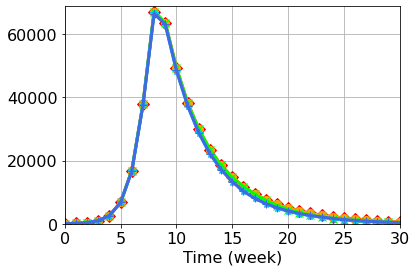

In [35]:
exhibition_index = 1
plot_to_compare_popluation_ovetime(population_c_and_s = simulation_test_population_c_and_s[exhibition_index],
                                   population_s1c2    = simulation_test_population_s1c2[exhibition_index],
                                   population_c1s2    = simulation_test_population_c1s2[exhibition_index],
                                   population_static  = simulation_test_population_static_optimal[exhibition_index],
                                   population_ccp     = simulation_test_population_ccp_optimal[exhibition_index],
                                   exhibition_length  = 30,
                                   size_font          = 16)
print("1 E = ", max(simulation_test_population_c_and_s[exhibition_index]))
print("2 E = ", max(simulation_test_population_s1c2[exhibition_index]))
print("3 E = ", max(simulation_test_population_c1s2[exhibition_index]))
print("4 E = ", max(simulation_test_population_static_optimal[exhibition_index]))
print("5 E = ", max(simulation_test_population_ccp_optimal[exhibition_index]))

# 7.2 Compare Infected population overtime

1 I =  32596.55037771303
2 I =  32596.55037771303
3 I =  32596.55037771303
4 I =  33981.6536539539
5 I =  33995.42654771927


<Figure size 432x288 with 0 Axes>

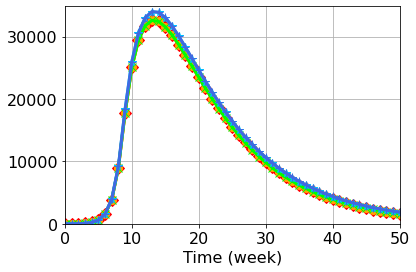

In [36]:
exhibition_index = 3
plot_to_compare_popluation_ovetime(population_c_and_s = simulation_test_population_c_and_s[exhibition_index],
                                   population_s1c2    = simulation_test_population_s1c2[exhibition_index],
                                   population_c1s2    = simulation_test_population_c1s2[exhibition_index],
                                   population_static  = simulation_test_population_static_optimal[exhibition_index],
                                   population_ccp     = simulation_test_population_ccp_optimal[exhibition_index],
                                   exhibition_length  = 50,
                                   size_font          = 16)
print("1 I = ", max(simulation_test_population_c_and_s[exhibition_index]))
print("2 I = ", max(simulation_test_population_s1c2[exhibition_index]))
print("3 I = ", max(simulation_test_population_c1s2[exhibition_index]))
print("4 I = ", max(simulation_test_population_static_optimal[exhibition_index]))
print("5 I = ", max(simulation_test_population_ccp_optimal[exhibition_index]))

# 7.3 Compare Death population overtime

1 D =  14710.884884979363
2 D =  14710.884884979363
3 D =  14685.715217246387
4 D =  15490.97913557723
5 D =  15532.014449745604


<Figure size 432x288 with 0 Axes>

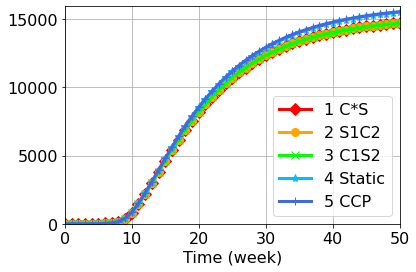

In [37]:
exhibition_index = 5
plot_to_compare_popluation_ovetime_legend(population_c_and_s = simulation_test_population_c_and_s[exhibition_index],
                                   population_s1c2    = simulation_test_population_s1c2[exhibition_index],
                                   population_c1s2    = simulation_test_population_c1s2[exhibition_index],
                                   population_static  = simulation_test_population_static_optimal[exhibition_index],
                                   population_ccp     = simulation_test_population_ccp_optimal[exhibition_index],
                                   exhibition_length  = 50,
                                   size_font          = 16)
print("1 D = ", max(simulation_test_population_c_and_s[exhibition_index]))
print("2 D = ", max(simulation_test_population_s1c2[exhibition_index]))
print("3 D = ", max(simulation_test_population_c1s2[exhibition_index]))
print("4 D = ", max(simulation_test_population_static_optimal[exhibition_index]))
print("5 D = ", max(simulation_test_population_ccp_optimal[exhibition_index]))